In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from itertools import product
from torchvision import models
from sklearn.cluster import KMeans
import random
import time

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# configures the model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name.lower() == "resnet18":
        # use a pre trained resnet18 model
        model = models.resnet18(weights='IMAGENET1K_V1' if use_pretrained else None)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name.lower() == "lenet":
        # create a custom LeNet model
        model = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes),
        )
    else:
        raise ValueError("Unsupported model name. Choose from ['resnet18', 'lenet']")

    return model.to(device)

In [18]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [19]:
# Downloads the dataset and applied a subset method
def prepare_dataset(dataset_name, input_size=224, subset_method="full", subset_fraction=0.1, model=None):
    mean, std = [0.5], [0.5]
    transform_train = transform_test = None

    # Downloads the dataset and applies a transformation
    if dataset_name.upper() == "CIFAR10":
        mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
        transform_train = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        transform_test = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

        # Load trainset and testset
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    elif dataset_name.upper() == "MNIST":
        mean, std = [0.1307], [0.3081]
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

        # Load trainset and testset
        trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
        testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
    else:
        raise ValueError("Unsupported dataset. Choose from ['CIFAR10', 'MNIST']")

    # Calls one of the subset selection functions
    print("Starting subset selection")
    if subset_method.lower() == "full":
        subset_trainset = trainset
    elif subset_method.lower() == "random":
        selected_indices = random_selection(trainset, fraction=subset_fraction)
        subset_trainset = Subset(trainset, selected_indices)
    elif subset_method.lower() == "grad_match":
        selected_indices = grad_match_selection(trainset, model, fraction=subset_fraction)
        subset_trainset = Subset(trainset, selected_indices)
    elif subset_method.lower() == "glister":
        val_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
        selected_indices = glister_selection(trainset, model, val_loader, fraction=subset_fraction)
        subset_trainset = Subset(trainset, selected_indices)
    elif subset_method.lower() == "craig":
        selected_indices = craig_selection(trainset, model, fraction=subset_fraction)
        subset_trainset = Subset(trainset, selected_indices)
    else:
        raise ValueError("Unsupported subset selection method.")
    print("Finished subset selection")

    return subset_trainset, testset

# Creates dataloaders for train and test set
def create_dataloaders(trainset, testset, batch_size):
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=5):
    best_val_accuracy = 0 # Tracks best accuracy
    epochs_without_improvement = 0 # Used for early stopping
    best_model_state = None # Stores the best model

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Evaluation on the validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Update best model if the accuracy has improved
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
            best_model_state = model.state_dict()
        else:
            epochs_without_improvement += 1

        # Early stopping if validation accuracy hasn't improved
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

    # Loads the best weights for the model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return best_val_accuracy

In [21]:
def grid_search(model_name, dataset_name, num_classes, param_grid, subset_method='full', subset_fraction=0.1):
    best_params = None # Stores the best hyperparameters
    best_accuracy = 0 # stores best validation accuracy
    best_time = 0 # Stores the time for the best model
    results = [] # Stores the results of each model

    print("Preparing dataset with subset selection...")
    # Initialize a model for subset selection if required
    model_for_subset = initialize_model(model_name, num_classes=num_classes, feature_extract=False, use_pretrained=True)
    subset_trainset, testset = prepare_dataset(dataset_name, input_size=224, subset_method=subset_method, subset_fraction=subset_fraction, model=model_for_subset)

    # Start timing for grid search only
    grid_search_start_time = time.time()

    # Iterate over all configurations of parameters in param grid
    for lr, batch_size, epochs in product(param_grid['lr'], param_grid['batch_size'], param_grid['epochs']):
        # Initialize model with current set of parameters
        model = initialize_model(model_name, num_classes=num_classes, feature_extract=False, use_pretrained=True)

        # Create dataloaders for train and validation set
        train_loader, val_loader = create_dataloaders(subset_trainset, testset, batch_size)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        # Train model and track time taken
        start_time = time.time()
        val_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs)
        end_time = time.time()
        training_time = end_time - start_time
        print()

        # Adds results to list
        results.append((lr, batch_size, epochs, val_accuracy, training_time))

        # Updates best model variables
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = (lr, batch_size, epochs)
            best_time = training_time

    # Calculates grid search time
    total_grid_search_time = time.time() - grid_search_start_time

    print(f"Best Hyperparameters: Learning Rate={best_params[0]}, Batch Size={best_params[1]}, Epochs={best_params[2]}")
    print(f"Best Validation Accuracy: {best_accuracy:.2f}%")
    print(f"Training Time for Best Configuration: {best_time:.2f} seconds")

    return best_params, best_accuracy, results, total_grid_search_time


In [22]:
# Randomly selects indices from the training set
def random_selection(dataset, fraction=0.05):
    num_samples = int(len(dataset) * fraction)
    selected_indices = random.sample(range(len(dataset)), num_samples)
    return selected_indices

# Selects indices based on the gradients to match the full dataset
def grad_match_selection(dataset, model, fraction=0.05, batch_size=32):
    model.eval()
    device = next(model.parameters()).device
    num_samples = int(len(dataset) * fraction) # Calculates the number of samples required

    all_gradients = []
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Calculates the gradient for each batch
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)

        # Computes the gradient with respect to the model parameters
        grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=False)

        # Adds gradints to list
        grad_norms = torch.cat([g.flatten() for g in grads if g is not None]).detach()
        all_gradients.append(grad_norms.cpu())

    all_gradients = torch.stack(all_gradients)

    # Selects indices using orthogonal matching pursuit
    selected_indices = orthogonal_matching_pursuit(all_gradients, num_samples)

    return selected_indices

def orthogonal_matching_pursuit(gradients, k):
    num_samples = gradients.shape[0] # total number of gradient vectors
    selected_indices = []
    residual = gradients.mean(dim=0) # residual for the mean gradient

    # selects samples interatively based on the inner product
    for _ in range(k):
        inner_products = torch.mv(gradients, residual)
        best_index = torch.argmax(inner_products).item() # Find the index with the largest inner product

        # Updated residual and add the selected index
        residual -= gradients[best_index]
        selected_indices.append(best_index)

    return selected_indices

# Selects a subset based on importance
def glister_selection(dataset, model, val_loader, fraction=0.05, batch_size=32):
    model.eval()
    device = next(model.parameters()).device
    num_samples = int(len(dataset) * fraction) # Calculates the number of samples to pick

    losses = []

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Calculates loss for each sample in the dataset
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels, reduction='none')

        # Stores the loss
        losses.extend(loss.detach().cpu().numpy())

    # Selects indices with the highest loss
    selected_indices = sorted(range(len(losses)), key=lambda i: losses[i], reverse=True)[:num_samples]
    return selected_indices

# selects a subset that best selects the dataset based on clustering using gradients
def craig_selection(dataset, model, fraction=0.05, batch_size=32):
    model.eval()
    device = next(model.parameters()).device
    num_samples = int(len(dataset) * fraction) # Calculates the number of samples to select

    gradients = [] # Store gradients
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Calculates gradient for each sample
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)

        # Adds gradient to list
        grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
        grad_vector = torch.cat([g.flatten() for g in grads if g is not None]).detach().cpu().numpy()
        gradients.append(grad_vector)

    gradients = np.array(gradients)

    num_clusters = min(num_samples, len(gradients))

    # Sets up K means clustering equal to the number of clusters to select
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(gradients)
    centers = kmeans.cluster_centers_

    # Selects the sample closest to each cluster
    selected_indices = []
    for center in centers:
        distances = np.linalg.norm(gradients - center, axis=1)
        selected_indices.append(np.argmin(distances))

    return selected_indices

In [23]:
# Tests a subset of data with grid search on the specified model and dataset
def test_subset(model_name, dataset_name, param_grid, subset_method="full"):
    num_classes = 10

    # Runs grid search to find the best parameters
    best_params, best_accuracy, results, grid_search_time = grid_search(model_name, dataset_name, num_classes, param_grid, subset_method)

    print(f"\nTotal Grid Search Time: {grid_search_time:.2f} seconds")
    print(f"Optimal Parameters: LR={best_params[0]}, Batch Size={best_params[1]}, Epochs={best_params[2]}")
    print(f"Validation Accuracy of Best Model: {best_accuracy:.2f}%")

    # Retrains the model with the optimal parameters
    print("\nRetraining with Optimal Parameters...")
    optimal_lr, optimal_batch_size, optimal_epochs = best_params

    # Initializes the new model for training
    model = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=optimal_lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Prepares the train and test set without subset selection
    trainset, testset = prepare_dataset(dataset_name, input_size=224)
    train_loader, val_loader = create_dataloaders(trainset, testset, optimal_batch_size)

    # Trains the model on the optimal parameters
    final_val_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=optimal_epochs)

    print(f"\nFinal Validation Accuracy with Best Parameters: {final_val_accuracy:.2f}%")

    return best_params, best_accuracy, final_val_accuracy, grid_search_time

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Plots the accuracies and times of different subset methods to compare
def plot_results(model, dataset, method_names, times_seconds, accuracies):
    times_hours = np.array(times_seconds) / 3600 # converts times to hours

    # Assumes index 0 is full dataset time
    full_time = times_hours[0]
    # Calculates the speedup for each method relative to full dataset
    speedups = [full_time / time for time in times_hours]

    colors = ["red", "blue", "orange", "green", "yellow"]

    # Creates a 1x2 figure for graphs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Adds each point to the scatter plot
    for i in range(len(method_names)):
        ax1.scatter(accuracies[i], times_hours[i], color=colors[i % len(colors)], label=method_names[i], s=100)


    ax1.set_xlabel("Accuracy (%)")
    ax1.set_ylabel("Time (Hours)")
    ax1.set_title(f"{model} on {dataset}: Accuracy vs Time for Different Subset Methods")

    # Creates bar plot for speedup times
    ax2.bar(method_names, speedups, color=colors[:len(method_names)])
    ax2.set_ylabel("Speedup (Relative to Full Dataset)")
    ax2.set_title(f"{model} on {dataset}: Speedup Comparison of Subset Methods")

    ax1.grid(color='gray', linestyle='--', linewidth=0.5)

    fig.legend(method_names, loc='upper center', ncol=len(method_names), bbox_to_anchor=(0.5, 1.1), frameon=False)

    plt.tight_layout()

    # Saves figure
    fig.savefig(f"{model}_{dataset}_performance_comparison.png", dpi=300, bbox_inches="tight")

    plt.show()


In [25]:
def run_all_subsets_and_plot(model_name, dataset_name, param_grid, subset_methods):
    times_seconds = [] # Stores grid search time for each method
    accuracies = [] # Stores accuracy for each method

    # Runs through each subset method
    for method in subset_methods:
        print(f"Testing subset method: {method}...")
         # Finds the best parameters through each method
        best_params, best_accuracy, final_val_accuracy, grid_search_time = test_subset(
            model_name=model_name,
            dataset_name=dataset_name,
            param_grid=param_grid,
            subset_method=method
        )
        print()

        # Adds values to each list
        times_seconds.append(grid_search_time)
        accuracies.append(final_val_accuracy)

    # Plots the results
    plot_results(model=model_name, dataset=dataset_name, method_names=subset_methods,
                 times_seconds=times_seconds, accuracies=accuracies)

Testing subset method: full...
Preparing dataset with subset selection...
Starting subset selection
Finished subset selection
Epoch 1/10, Loss: 0.3220, Val Accuracy: 97.60%
Epoch 2/10, Loss: 0.0684, Val Accuracy: 98.60%
Epoch 3/10, Loss: 0.0488, Val Accuracy: 98.45%
Epoch 4/10, Loss: 0.0379, Val Accuracy: 98.75%
Epoch 5/10, Loss: 0.0324, Val Accuracy: 98.73%
Epoch 6/10, Loss: 0.0272, Val Accuracy: 98.94%
Epoch 7/10, Loss: 0.0229, Val Accuracy: 98.84%
Epoch 8/10, Loss: 0.0199, Val Accuracy: 98.76%
Epoch 9/10, Loss: 0.0184, Val Accuracy: 99.02%
Epoch 10/10, Loss: 0.0140, Val Accuracy: 98.80%

Epoch 1/15, Loss: 0.2719, Val Accuracy: 97.37%
Epoch 2/15, Loss: 0.0643, Val Accuracy: 97.71%
Epoch 3/15, Loss: 0.0466, Val Accuracy: 98.36%
Epoch 4/15, Loss: 0.0359, Val Accuracy: 98.91%
Epoch 5/15, Loss: 0.0301, Val Accuracy: 98.75%
Epoch 6/15, Loss: 0.0237, Val Accuracy: 98.95%
Epoch 7/15, Loss: 0.0193, Val Accuracy: 98.91%
Epoch 8/15, Loss: 0.0184, Val Accuracy: 99.17%
Epoch 9/15, Loss: 0.0145, 

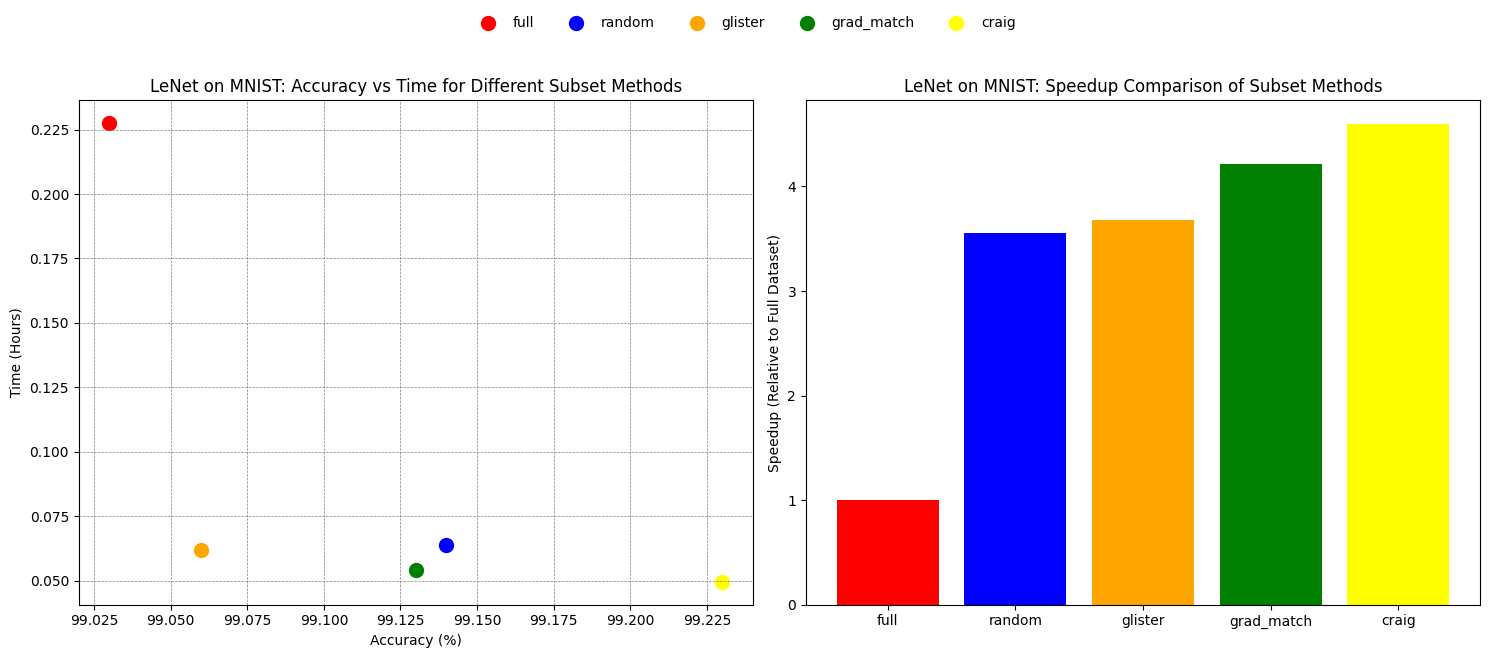

In [26]:
model_name = "LeNet" # ["LeNet", "resnet18"]
dataset_name = "MNIST" # ['MNIST', 'CIFAR10']
param_grid_resnet = { 'lr': [0.005, 0.01, 0.015], 'batch_size': [32, 64, 128], 'epochs': [10, 15, 20, 25]}
param_grid_lenet = { 'lr': [0.005, 0.01, 0.015], 'batch_size': [16, 32, 64, 128], 'epochs': [5, 10, 15, 20]}
param_grid_demo = { 'lr': [0.005, 0.01], 'batch_size': [32, 64], 'epochs': [10, 15]}
subset_methods = ["full", "random", "glister", "grad_match", "craig"]

run_all_subsets_and_plot(model_name, dataset_name, param_grid_demo, subset_methods)